In [29]:
from skimage.transform import radon, iradon
import pydicom as dicom
import numpy as np
import os
from glob import glob
import re
import matplotlib.pyplot as plt

In [6]:
path = "../data/dicom/"

In [56]:
high_metal_folder = [
            sorted(
                glob(
                    os.path.join(path, "high_metal/acquisition_" + str(i) + "/*")
                ),
                key=lambda x: [
                    int(c) if c.isdigit() else c for c in re.split(r"(\d+)", x)
                ],
            )
            for i in range(11)
        ]
high_metal_folder[1][:5]

['../data/dicom/high_metal/acquisition_1/001.dcm',
 '../data/dicom/high_metal/acquisition_1/002.dcm',
 '../data/dicom/high_metal/acquisition_1/003.dcm',
 '../data/dicom/high_metal/acquisition_1/004.dcm',
 '../data/dicom/high_metal/acquisition_1/005.dcm']

/Users/hugo/opt/miniconda3/envs/artefact/lib/python3.9/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


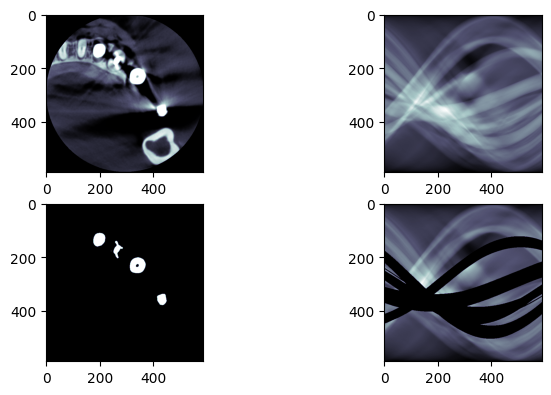

In [96]:
y = dicom.dcmread(high_metal_folder[1][200]).pixel_array
theta = np.linspace(0.0, 180.0, max(y.shape), endpoint=False)
y = y / max(y.flatten()) 
metal = y >=1
sinogram_y = radon(y, theta=theta, circle=True)
sinogram_metal = radon(metal, theta=theta, circle=True)
sinogram_without_metal = (1-sinogram_metal>=1)*sinogram_y
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(8, 4.5))
ax1[0].imshow(y, cmap=plt.cm.bone)
ax2[0].imshow(metal, cmap=plt.cm.bone, )

ax1[1].imshow(sinogram_y, cmap=plt.cm.bone)
ax2[1].imshow(sinogram_without_metal, cmap=plt.cm.bone)

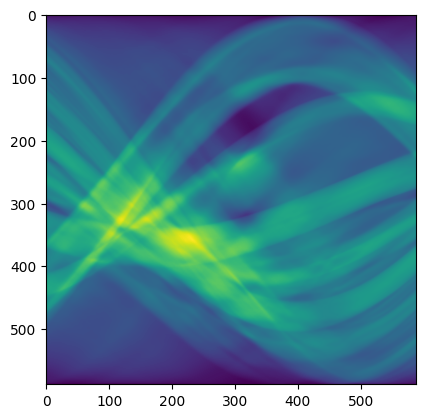

In [101]:
max(sinogram_y.flatten())

plt.imshow(sinogram_y/sinogram_y.max())

In [26]:
back = iradon(sinogram_y, theta=theta, circle=True)
back

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [102]:
sinogram_y = sinogram_y/sinogram_y.max()

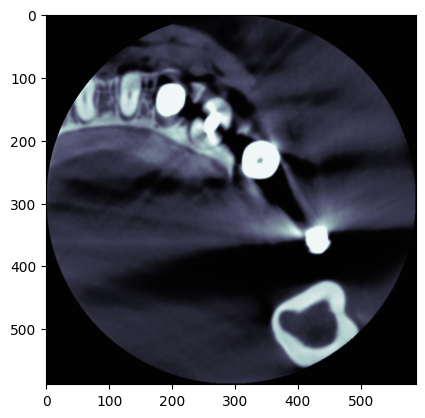

In [103]:
y = iradon(sinogram_y, theta=theta, circle=True)
plt.imshow(y, cmap=plt.cm.bone)

In [114]:
import pydicom
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids


image2d = y
image2d = image2d.astype(np.uint16)

print("Setting file meta information...")
# Populate required values for file meta information

meta = pydicom.Dataset()
meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

ds = Dataset()
ds.file_meta = meta

ds.is_little_endian = True
ds.is_implicit_VR = False

ds.SOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
ds.PatientName = "Test^Firstname"
ds.PatientID = "123456"

ds.Modality = "MR"
ds.SeriesInstanceUID = pydicom.uid.generate_uid()
ds.StudyInstanceUID = pydicom.uid.generate_uid()
ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

ds.BitsStored = 16
ds.BitsAllocated = 16
ds.SamplesPerPixel = 1
ds.HighBit = 15

ds.ImagesInAcquisition = "1"

ds.Rows = image2d.shape[0]
ds.Columns = image2d.shape[1]
ds.InstanceNumber = 1

ds.ImagePositionPatient = r"0\0\1"
ds.ImageOrientationPatient = r"1\0\0\0\-1\0"
ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"

ds.RescaleIntercept = "0"
ds.RescaleSlope = "1"
ds.PixelSpacing = r"1\1"
ds.PhotometricInterpretation = "MONOCHROME2"
ds.PixelRepresentation = 1

pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)

print("Setting pixel data...")
ds.PixelData = image2d.tobytes()

ds.save_as(r"out.dcm", write_like_original=False)

Setting file meta information...
Setting pixel data...


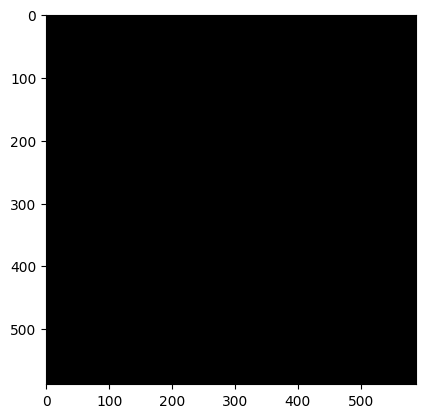

In [115]:
test = dicom.dcmread("out.dcm", )
test.pixel_array
plt.imshow(test.pixel_array, cmap=plt.cm.bone)